<a href="https://colab.research.google.com/github/Culeshovi/deep-learning/blob/master/retina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(


q="name = 'DRIVE.zip'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/DRIVE.zip"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [2]:
!unzip DRIVE.zip

Archive:  DRIVE.zip
   creating: DRIVE/test/
   creating: DRIVE/test/1st_manual/
 extracting: DRIVE/test/1st_manual/12_manual1.gif  
 extracting: DRIVE/test/1st_manual/02_manual1.gif  
 extracting: DRIVE/test/1st_manual/03_manual1.gif  
 extracting: DRIVE/test/1st_manual/04_manual1.gif  
 extracting: DRIVE/test/1st_manual/05_manual1.gif  
 extracting: DRIVE/test/1st_manual/06_manual1.gif  
 extracting: DRIVE/test/1st_manual/07_manual1.gif  
 extracting: DRIVE/test/1st_manual/08_manual1.gif  
 extracting: DRIVE/test/1st_manual/09_manual1.gif  
 extracting: DRIVE/test/1st_manual/10_manual1.gif  
 extracting: DRIVE/test/1st_manual/11_manual1.gif  
 extracting: DRIVE/test/1st_manual/01_manual1.gif  
 extracting: DRIVE/test/1st_manual/13_manual1.gif  
 extracting: DRIVE/test/1st_manual/14_manual1.gif  
 extracting: DRIVE/test/1st_manual/15_manual1.gif  
 extracting: DRIVE/test/1st_manual/16_manual1.gif  
 extracting: DRIVE/test/1st_manual/17_manual1.gif  
 extracting: DRIVE/test/1st_manual/

In [3]:
import os
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')
import keras.backend as K

from keras.models import Sequential,Model


from keras.layers import MaxPooling2D,Reshape,Cropping2D,Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D,BatchNormalization,UpSampling2D,Conv2DTranspose
from keras.utils import np_utils



Using TensorFlow backend.


In [41]:
!ls


retina_result_weights.best.hdf5  test  training


In [0]:
os.chdir('DRIVE')



In [0]:
def cropIM(im,tm,size=[64,64]):
    w,h=im.size
    w_max,h_max = w-size[0],h-size[1]
    l,d=np.random.randint(0,w_max+1),np.random.randint(0,h_max+1)
    return im.crop(box=(l,d,l+size[0],d+size[1])),tm.crop(box=(l,d,l+size[0],d+size[1]))

In [0]:
def histo_equalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = cv2.equalizeHist(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized

In [0]:
def clahe_equalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    #create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = clahe.apply(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized


In [0]:
def dataset_normalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))*255
    return imgs_normalized


def adjust_gamma(imgs, gamma=1.0):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    new_imgs = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        new_imgs[i,0] = cv2.LUT(np.array(imgs[i,0], dtype = np.uint8), table)
    return new_imgs

In [0]:
def rgb2gray(rgb):
    assert (len(rgb.shape)==4)  #4D arrays
    assert (rgb.shape[1]==3)
    bn_imgs = rgb[:,0,:,:]*0.299 + rgb[:,1,:,:]*0.587 + rgb[:,2,:,:]*0.114
    bn_imgs = np.reshape(bn_imgs,(rgb.shape[0],1,rgb.shape[2],rgb.shape[3]))
    return bn_imgs


In [0]:
def my_PreProc(data):
    assert(len(data.shape)==4)
    assert (data.shape[1]==3)  #Use the original images
    #black-white conversion
    train_imgs = rgb2gray(data)
    #my preprocessing:
    train_imgs = dataset_normalized(train_imgs)
    train_imgs = clahe_equalized(train_imgs)
    train_imgs = adjust_gamma(train_imgs, 1.2)
    train_imgs = train_imgs/255.  #reduce to 0-1 range
    return train_imgs

In [0]:
data=os.listdir('training/images')
label=os.listdir('training/1st_manual')
data.sort()
label.sort()


In [0]:
from PIL import Image
DATA=[]
LABEL=[]


for i in range(len(data)):
  im=Image.open('training/images/'+data[i])
  #res=im.resize((512, 512), Image.ANTIALIAS)
  im2=Image.open('training/1st_manual/'+label[i])
  #res2=im2.resize((512, 512), Image.ANTIALIAS)
  #im3=Image.open('training/mask/'+str(21+i)+'_training_mask.gif')
  seg=np.array(im2)/255
  #mask=(np.array(im3)/255-seg)
  #idx=np.where(mask==1)
  #seg[idx]=2
  for j in range(600):
    res,res2=cropIM(im,Image.fromarray(seg))
    DATA.append(np.array(res))
    LABEL.append(np.expand_dims(res2,axis=-1))




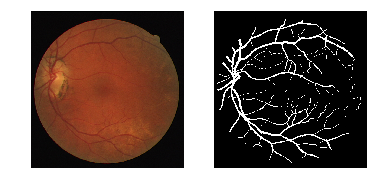

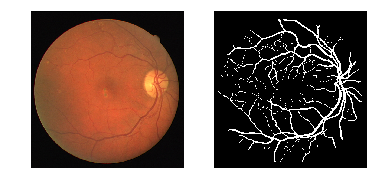

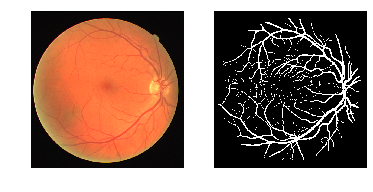

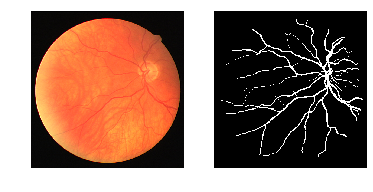

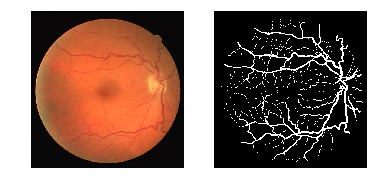

In [8]:
tick=5
while (tick>0):
  fig, (ax1 ,ax2) = plt.subplots(1, 2)
  ax1.imshow(DATA[tick],cmap='bone')
  ax2.imshow(np.squeeze(LABEL[tick],-1),cmap='bone')
  ax1.axis('off')
  ax2.axis('off')
  tick=tick-1

In [0]:
DATA=np.stack(DATA,0)
LABEL=np.stack(LABEL,0)

In [29]:
DATA=np.rollaxis(DATA,3, 1) 
print (DATA.shape)
print (LABEL.shape)

(12000, 3, 64, 64)
(12000, 64, 64, 1)


In [30]:
print (DATA.shape)

(12000, 3, 64, 64)


In [0]:
DATA=my_PreProc(DATA)

In [0]:
DATA=np.moveaxis(DATA,1, 3)

In [33]:
in_lay=Input((None,None,1))


l1=Conv2D(128, kernel_size = (4,4),strides=(2,2), padding = 'same',activation = 'relu')(in_lay)
l1=BatchNormalization()(l1)

l1=Conv2D(128, kernel_size = (4,4),strides=(2,2), padding = 'same',activation = 'relu')(l1)
l1=BatchNormalization()(l1)

l1=Conv2D(512, kernel_size = (4,4),strides=(2,2), padding = 'same',activation = 'relu')(l1)
l1=BatchNormalization()(l1)

#l1=Conv2D(512, kernel_size = (4,4),strides=(2,2), padding = 'same',activation = 'relu')(l1)
#l1=BatchNormalization()(l1)

#l1=Conv2D(1024, kernel_size = (4,4),strides=(2,2), padding = 'same',activation = 'relu')(l1)
#l1=BatchNormalization()(l1)




#l3=Conv2DTranspose(256, kernel_size = (4,4),strides=(2,2), padding = 'same',activation = 'relu')(l1)
#l3=BatchNormalization()(l3)

#l3=Conv2DTranspose(128, kernel_size = (4,4),strides=(2,2), padding = 'same',activation = 'relu')(l3)
#l3=BatchNormalization()(l3)

#l3=Conv2DTranspose(512, kernel_size = (4,4),strides=(2,2), padding = 'same',activation = 'relu')(l1)
#l3=BatchNormalization()(l3)

l3=Conv2DTranspose(128, kernel_size = (4,4),strides=(2,2), padding = 'same',activation = 'relu')(l1)
l3=BatchNormalization()(l3)

l3=Conv2DTranspose(128, kernel_size = (4,4),strides=(2,2), padding = 'same',activation = 'relu')(l3)
l3=BatchNormalization()(l3)


Out=Conv2DTranspose(1, kernel_size = (4,4),strides=(2,2),padding = 'same')(l3)



model=Model(inputs = [in_lay], outputs = [Out])
model.compile(optimizer = 'adam', loss = 'mse',
                           metrics=['accuracy'])
model.summary()






















_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 128)   2176      
_________________________________________________________________
batch_normalization_6 (Batch (None, None, None, 128)   512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 128)   262272    
_________________________________________________________________
batch_normalization_7 (Batch (None, None, None, 128)   512       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 512)   1049088   
_________________________________________________________________
batch_normalization_8 (Batch (None, None, None, 512)   2048      
__________

In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('retina_result')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0000001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=150)
callbacks_list = [checkpoint, early, reduceLROnPlat,] 

In [35]:
hist=model.fit(DATA,LABEL,batch_size=1200,validation_split=0.1,callbacks = callbacks_list,epochs=100)

Train on 10800 samples, validate on 1200 samples
Epoch 1/100
10800/10800 [==============================] - 19s 2ms/step - loss: 0.3203 - acc: 0.7368 - val_loss: 0.9174 - val_acc: 0.5399

Epoch 00001: val_loss improved from inf to 0.91740, saving model to retina_result_weights.best.hdf5
Epoch 2/100
10800/10800 [==============================] - 15s 1ms/step - loss: 0.1015 - acc: 0.8887 - val_loss: 0.2054 - val_acc: 0.7799

Epoch 00002: val_loss improved from 0.91740 to 0.20543, saving model to retina_result_weights.best.hdf5
Epoch 3/100
10800/10800 [==============================] - 15s 1ms/step - loss: 0.0812 - acc: 0.9009 - val_loss: 0.1087 - val_acc: 0.8740

Epoch 00003: val_loss improved from 0.20543 to 0.10869, saving model to retina_result_weights.best.hdf5
Epoch 4/100
10800/10800 [==============================] - 15s 1ms/step - loss: 0.0704 - acc: 0.9133 - val_loss: 0.1216 - val_acc: 0.8490

Epoch 00004: val_loss did not improve from 0.10869
Epoch 5/100
10800/10800 [===========

In [38]:
from PIL import Image
DATA1=[]
LABEL1=[]
REAL=[]


for i in range(len(data)):
  im=Image.open('training/images/'+data[i])
  res=im.resize((512, 512), Image.ANTIALIAS)
  REAL.append(np.array(res))
  DATA1.append(np.array(res))
DATA1=np.stack(DATA1)
DATA1=np.rollaxis(DATA1,3, 1) 
DATA1=my_PreProc(DATA1)
DATA1=np.moveaxis(DATA1,1, 3)

print (DATA1.shape)

(20, 512, 512, 1)


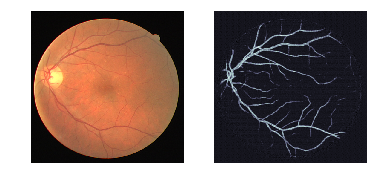

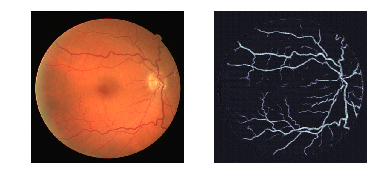

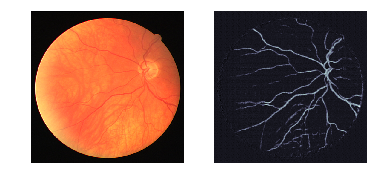

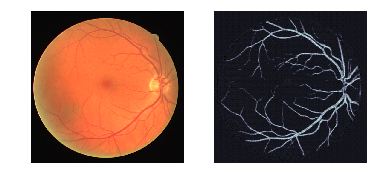

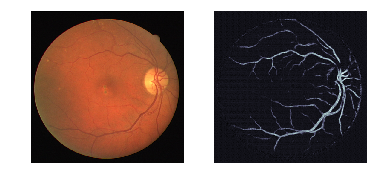

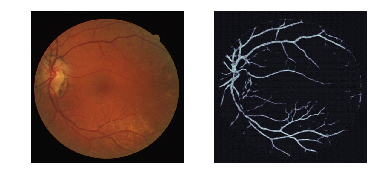

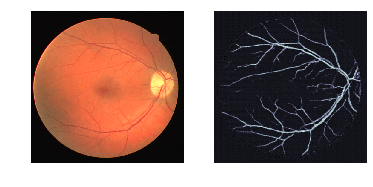

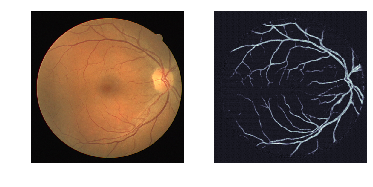

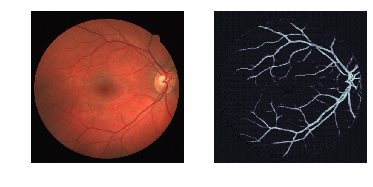

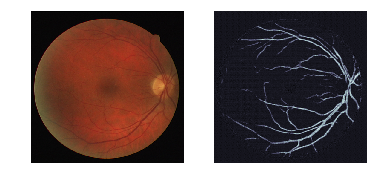

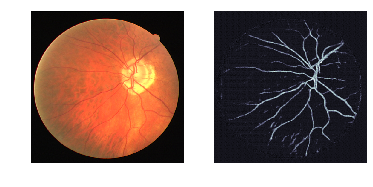

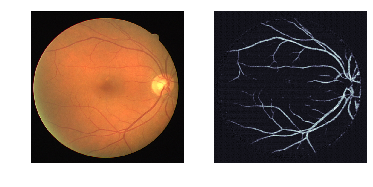

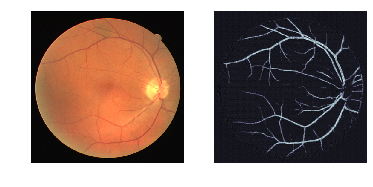

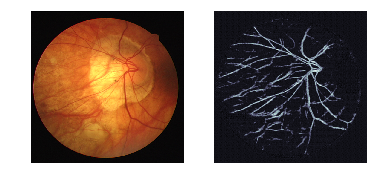

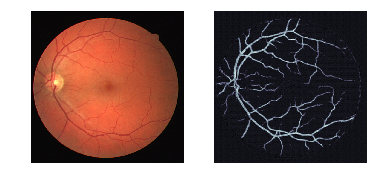

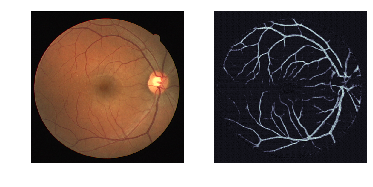

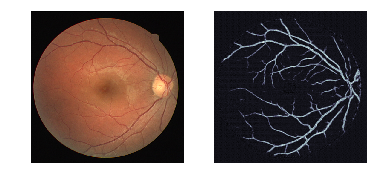

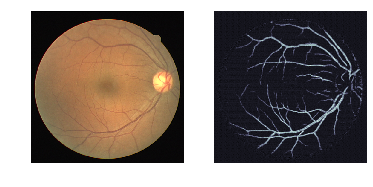

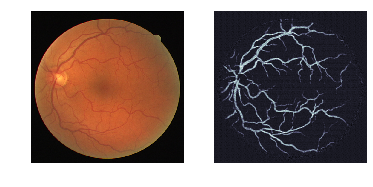

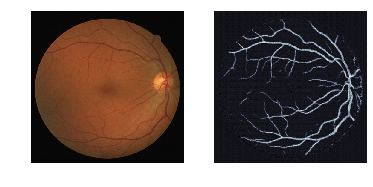

In [39]:
for i in range(len(data)):
  fig, (ax1, ax2) = plt.subplots(1,2)
  
  ax1.imshow(REAL[i],cmap='bone')
  pred=model.predict(np.expand_dims(DATA1[i],axis=0))
  #im3=Image.open('training/mask/'+str(21+i)+'_training_mask.gif')
  pred=np.squeeze(pred,axis=-1)
  pred=np.squeeze(pred,axis=0)
  #im3=im3.resize((512, 512), Image.ANTIALIAS)
  pred=(pred*255.0)
  ax2.imshow(pred,cmap='bone')
  ax1.axis('off')
  ax2.axis('off')
  


In [42]:
from PIL import Image
DATA1=[]
LABEL1=[]
REAL=[]
data1=os.listdir('test/images/')


for i in range(len(data)):
  im=Image.open('test/images/'+data1[i])
  res=im.resize((512, 512), Image.ANTIALIAS)
  REAL.append(np.array(res))
  DATA1.append(np.array(res))
DATA1=np.stack(DATA1)
DATA1=np.rollaxis(DATA1,3, 1) 
DATA1=my_PreProc(DATA1)
DATA1=np.moveaxis(DATA1,1, 3)

print (DATA1.shape)

(20, 512, 512, 1)


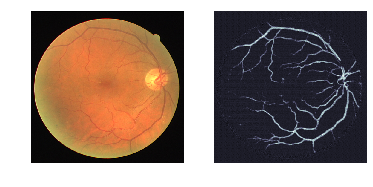

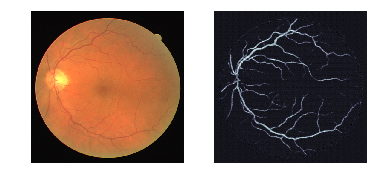

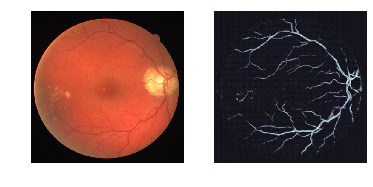

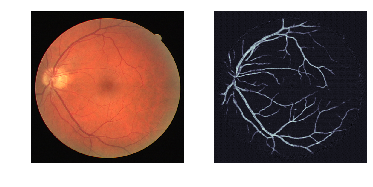

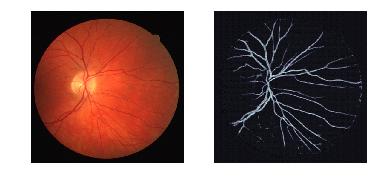

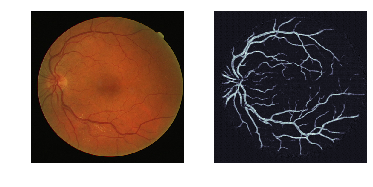

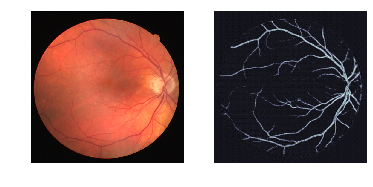

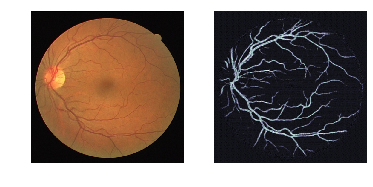

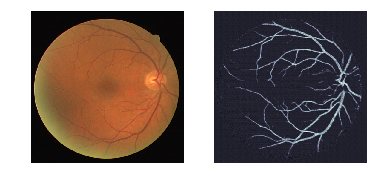

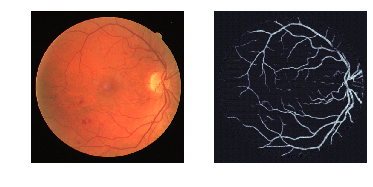

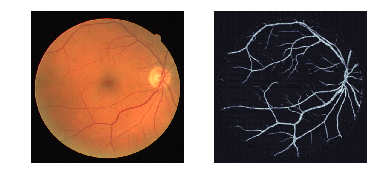

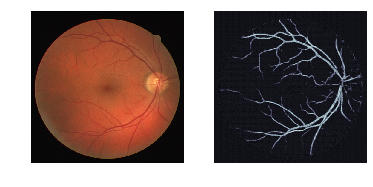

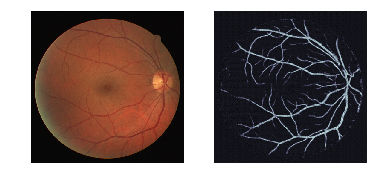

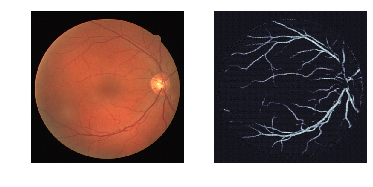

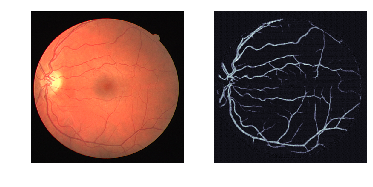

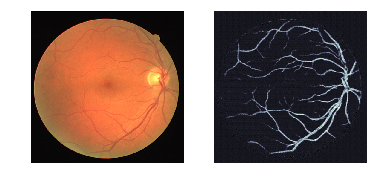

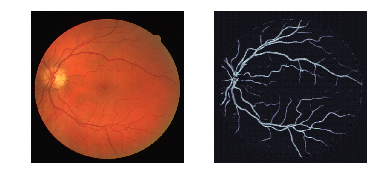

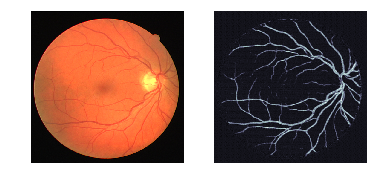

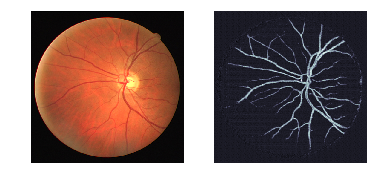

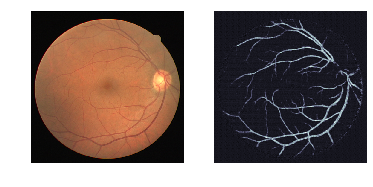

In [43]:
for i in range(len(data)):
  fig, (ax1, ax2) = plt.subplots(1,2)
  
  ax1.imshow(REAL[i],cmap='bone')
  pred=model.predict(np.expand_dims(DATA1[i],axis=0))
  #im3=Image.open('training/mask/'+str(21+i)+'_training_mask.gif')
  pred=np.squeeze(pred,axis=-1)
  pred=np.squeeze(pred,axis=0)
  #im3=im3.resize((512, 512), Image.ANTIALIAS)
  pred=(pred*255.0)
  ax2.imshow(pred,cmap='bone')
  ax1.axis('off')
  ax2.axis('off')

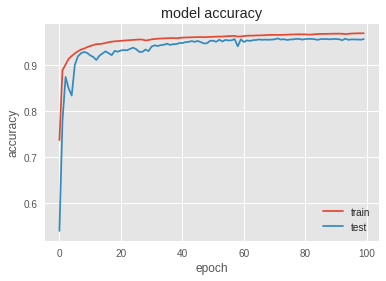

In [36]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

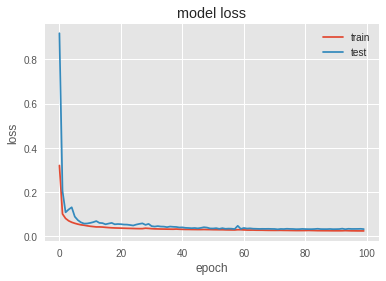

In [37]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()